# MobileNet Image Classification with TensorFlow's Keras API

A class of light weight deep convolutional neural networks that are vastly smaller in size and faster in performance than may other populat models.

MobileNets are a class of small, low-latency, low-power models that can be used for classification, detection, and other common tasks convolutional neural networks are good for.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline 

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Availabel : ',len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

Num GPUs Availabel :  1


In [3]:
mobile = tf.keras.applications.mobilenet.MobileNet() # Downloading the Mobile-Net model

17227776/17225924 [==============================] - 2s 0us/step


In [16]:
# Seeing Visualization through Mobile-Net

def prepare_image(file) :
    img_path = r'C:\Local Disk\Programming\Python Projects\keras complete\data\MobileNet-samples'
    img = image.load_img(os.path.join(img_path,file), target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

# imgae.load_img() is from the Keras API

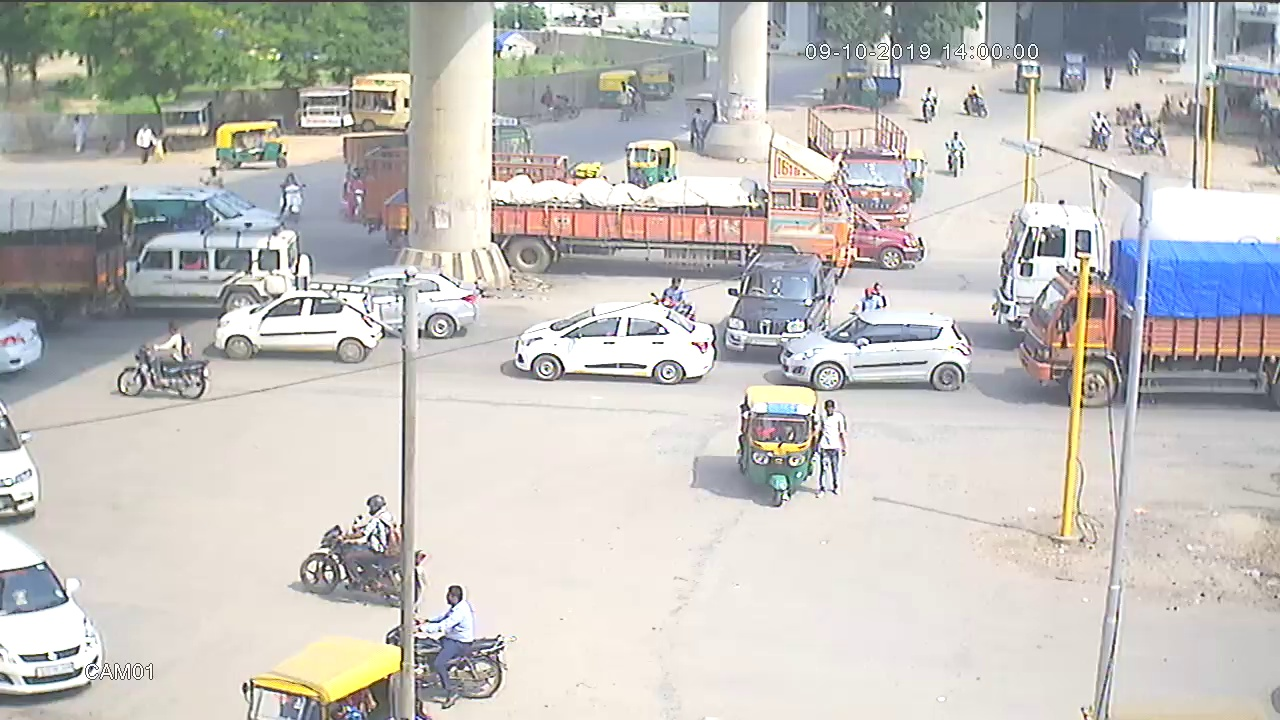

In [17]:
from IPython.display import Image
Image(filename = r"C:\Local Disk\Programming\Python Projects\keras complete\data\MobileNet-samples\1.jpg",width=224,height=224)

In [19]:
preprocessed_image = prepare_image('1.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions) # returns Top5 predictions from the Mobile-net Image classes
results

40960/35363 [==================================] - 0s 3us/step


[[('n03345487', 'fire_engine', 0.12207612),
  ('n04483307', 'trimaran', 0.09592799),
  ('n04037443', 'racer', 0.07111719),
  ('n09428293', 'seashore', 0.06713185),
  ('n02966193', 'carousel', 0.058760922)]]

In [26]:
results[0][0][1] # The top-most result

'fire_engine'

# Fine-Tuning Model for custom data-set.

The considered Labels were not already present in the Image-Net library.

Dataset :

- Dataset of sign language digits ( 0-9 )
- Available on Kaggle as Black and White, and on Github as RGB dataset.
- Link : https://github.com/ardamavi/Sign-Language-Digits-Dataset

In [29]:
# organizing data into train, valid, test dirs

os.chdir(r'C:\Local Disk\Programming\Python Projects\keras complete\Sign language Dataset\Processed')

if os.path.isdir('train/0/') is False :
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    for i in range(0,10) :
        
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')
        
        valid_samples = random.sample(os.listdir(f'train/{i}'),30)
        
        for j in valid_samples :
            shutil.move(f'train/{i}/{j}',f'valid/{i}')
            
        test_samples = random.sample(os.listdir(f'train/{i}'),5)
        
        for j in test_samples :
            shutil.move(f'train/{i}/{j}',f'test/{i}')
            
os.chdir('..\..')

In [31]:
train_path = r"C:\Local Disk\Programming\Python Projects\keras complete\Sign language Dataset\Processed\train"
valid_path = r"C:\Local Disk\Programming\Python Projects\keras complete\Sign language Dataset\Processed\valid"
test_path = r"C:\Local Disk\Programming\Python Projects\keras complete\Sign language Dataset\Processed\test"

In [32]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
.flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
.flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
.flow_from_directory(directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


# Modify Model for Custom-data-set

In [33]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [35]:
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    return {'non_trainable_params' : non_trainable_params, 'trainable_params' : trainable_params}

In [36]:
params = count_params(mobile)

params

{'non_trainable_params': 21888, 'trainable_params': 4231976}

In [37]:
x = mobile.layers[-6].output # takes all layers upto the 6th to last layer - i.e we are not going to include the last 5 layers

output = Dense(units=10,activation='softmax')(x)

# The mobile net model is a functional model. So this is from the functional model API.

In [41]:
model = Model(inputs=mobile.input, outputs=output)

In [42]:
for layer in model.layers[:-23]:
    layer.trainable = False # by default all layers are trainable

In [43]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

# Train the model

In [44]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
model.fit(x=train_batches, validation_data=valid_batches,epochs=30,verbose=2)

Epoch 1/30
172/172 - 4s - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0340 - val_accuracy: 0.9900
Epoch 2/30
172/172 - 3s - loss: 0.0059 - accuracy: 0.9994 - val_loss: 0.0458 - val_accuracy: 0.9900
Epoch 3/30
172/172 - 3s - loss: 0.0056 - accuracy: 0.9994 - val_loss: 0.0317 - val_accuracy: 0.9867
Epoch 4/30
172/172 - 3s - loss: 0.0113 - accuracy: 0.9982 - val_loss: 0.1508 - val_accuracy: 0.9467
Epoch 5/30
172/172 - 3s - loss: 0.0075 - accuracy: 0.9994 - val_loss: 0.0186 - val_accuracy: 0.9967
Epoch 6/30
172/172 - 3s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0188 - val_accuracy: 0.9933
Epoch 7/30
172/172 - 3s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0148 - val_accuracy: 1.0000
Epoch 8/30
172/172 - 3s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 9/30
172/172 - 3s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0207 - val_accuracy: 0.9900
Epoch 10/30
172/172 - 3s - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0220 - val_accuracy: 0.9867

# Predict sign language digits

In [47]:
test_labels = test_batches.classes

In [48]:
predictions = model.predict(x=test_batches, verbose=2)

5/5 - 0s


In [49]:
cm = confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(predictions,axis=1))

In [53]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap = plt.cm.Blues):
    
    
    """
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    
    """
    
    plt.imshow(cm, interpolation='nearest',cmap=cmap) # defining blue color-maps
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    if normalize :
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized Confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max()/ 2.
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


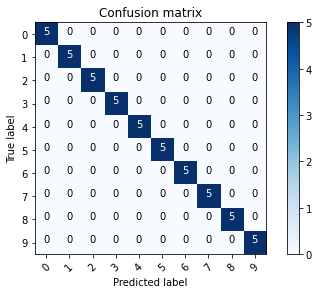

In [54]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title = "Confusion matrix")